In [1]:
import os
import sys
import re
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import seaborn as sns
%matplotlib inline

# Enable relative imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from text.analytics import TermFreqInverseDocFreq

/Users/jeremy/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Load Fuana Dataset

In [2]:
df = pd.read_csv('../data/fauna.csv.gz', compression='gzip')
df = df.set_index(keys=['page-id'])
df.head()

,class,family,genus,kingdom,order,phylum,species,text,title
page-id,,,,,,,,,
3451749,amphibia,ranidae,rana,animalia,anura,chordata,rboylii,The foothill yellow-legged frog (Rana boylii) ...,Foothill yellow-legged frog
38082824,amphibia,ranidae,lithobates,animalia,anura,chordata,lsylvaticus,This is a redirect from a title with another m...,Wood Frog
1369072,mammalia,bovidae,pantholopshodgson18342,animalia,artiodactyla,chordata,phodgsonii,The Tibetan antelope or chiru (Pantholops hodg...,Tibetan antelope
26625724,mammalia,bovidae,damaliscus,animalia,artiodactyla,chordata,dsuperstes,The Bangweulu tsessebe (Damaliscus superstes) ...,Bangweulu tsessebe
1709509,mammalia,tayassuidae,catagonusameghino1904,animalia,artiodactyla,chordata,cbrachydontuscmetropolitanuscstenocephaluscwag...,The Chacoan peccary or tagua (Catagonus wagner...,Chacoan peccary


## Visualize the number of records in each class

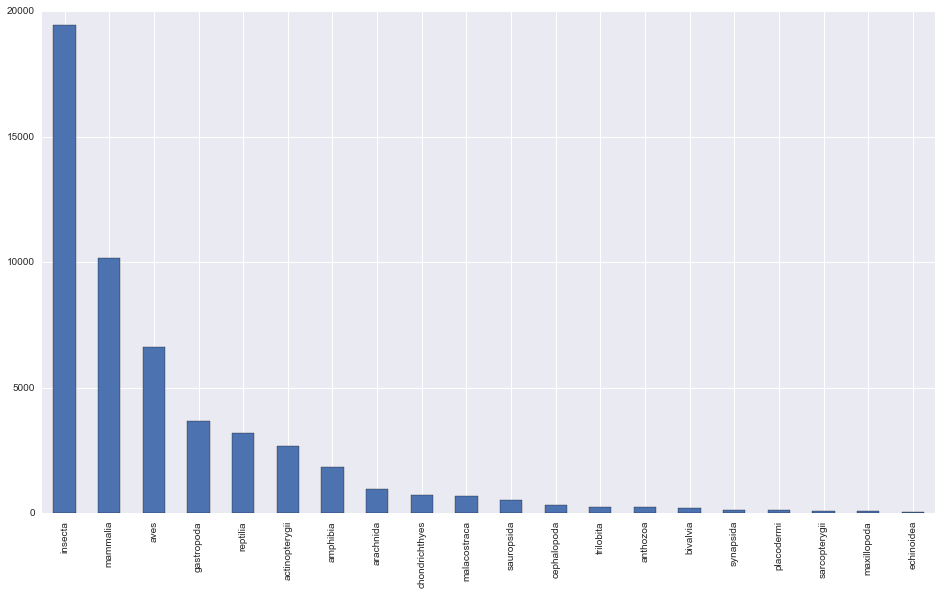

In [3]:
classes = df['class'].value_counts()
figure(figsize=(16, 9))
classes[0:20].plot(kind="bar")

### Create a TFIDF Table

In [4]:
tfidf = TermFreqInverseDocFreq()
tfidf.create(df, 'text', True)

create()
Term frequency created
Term frequency normalized
Document frequency created
TFIDF created
Page Index 2 Word Index 145
Page: 1369072 Term: at
Number of Pages containing term: 11047
Global Rarity: 1.61776663682
Local frequency 0.0426358368384
Gloabl frequency: 11047.0
TFIDF 0.0689748343703


In [5]:
tfid_df = pd.SparseSeries.from_coo(tfidf.tfidf.tocoo(), dense_index=False)

In [15]:
tfidf.tfidf[0].shape

(1, 255681)